In [2]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

import math

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

In [27]:
catalog_path = '/home/polaris/Lab_Astro/data/cigale/all_data_6/out7/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_CIGALE.fits'
catalog_table = Table.read(catalog_path)
catalog_pd = catalog_table.to_pandas()

print([_ for _ in catalog_pd.columns.tolist() if _.startswith('bayes')])

['bayes.agn.EBV', 'bayes.agn.EBV_err', 'bayes.agn.Mcl', 'bayes.agn.Mcl_err', 'bayes.agn.R', 'bayes.agn.R_err', 'bayes.agn.delta', 'bayes.agn.delta_err', 'bayes.agn.disk_type', 'bayes.agn.disk_type_err', 'bayes.agn.emissivity', 'bayes.agn.emissivity_err', 'bayes.agn.fracAGN', 'bayes.agn.fracAGN_err', 'bayes.agn.i', 'bayes.agn.i_err', 'bayes.agn.law', 'bayes.agn.law_err', 'bayes.agn.oa', 'bayes.agn.oa_err', 'bayes.agn.pl', 'bayes.agn.pl_err', 'bayes.agn.q', 'bayes.agn.q_err', 'bayes.agn.t', 'bayes.agn.t_err', 'bayes.agn.temperature', 'bayes.agn.temperature_err', 'bayes.attenuation.Av_BC', 'bayes.attenuation.Av_BC_err', 'bayes.attenuation.BC_to_ISM_factor', 'bayes.attenuation.BC_to_ISM_factor_err', 'bayes.attenuation.galex.FUV', 'bayes.attenuation.galex.FUV_err', 'bayes.attenuation.generic.bessell.B', 'bayes.attenuation.generic.bessell.B_err', 'bayes.attenuation.generic.bessell.V', 'bayes.attenuation.generic.bessell.V_err', 'bayes.attenuation.slope_BC', 'bayes.attenuation.slope_BC_err', '

# Histogram of all results

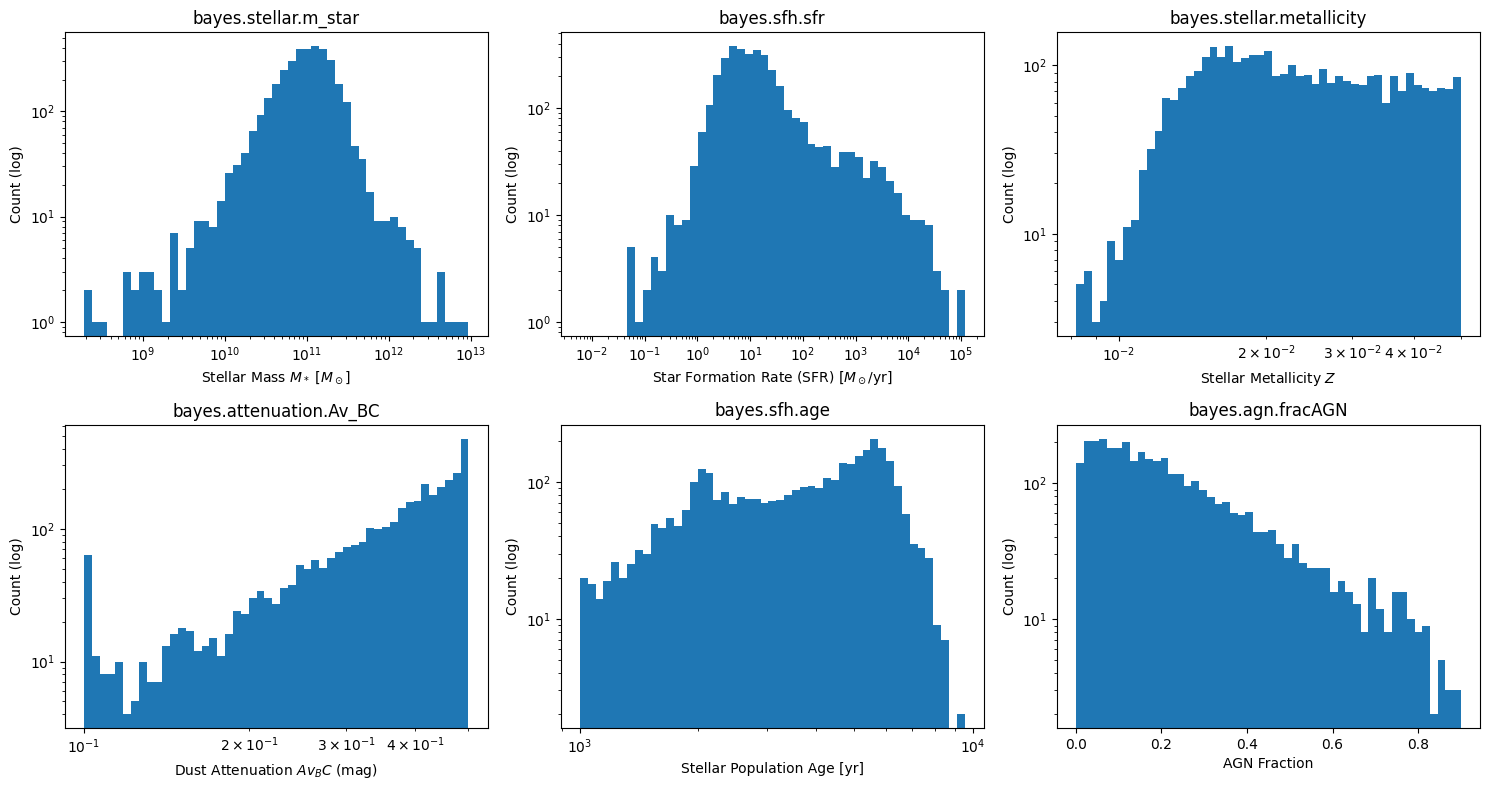

In [6]:
def plot_log_histograms_2rows_hist(df, columns, x_labels, figsize=(15, 8)):
    """
    Plot histograms (using .hist()) of specified DataFrame columns in 2 rows,
    with log-log scaling on both axes except for specific exceptions.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to plot
    - x_labels: list of x-axis labels (same length as columns)
    - figsize: figure size (width, height)
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]

        data = df[col].dropna()

        # Identify whether to use log x-axis
        if 'bayes.agn.fracAGN' in col:
            # Linear x-axis bins
            bins = 50
            ax.hist(data, bins=bins)
            ax.set_yscale('log')  # Still use log y
        else:
            data = data[data > 0]  # log scale requires strictly positive values
            bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 50)
            ax.hist(data, bins=bins)
            ax.set_xscale('log')
            ax.set_yscale('log')

        ax.set_title(col)
        ax.set_xlabel(x_labels[i])
        ax.set_ylabel('Count (log)')

    # Hide any unused subplots
    total_plots = nrows * ncols
    for j in range(n, total_plots):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

x_labels = [
    r"Stellar Mass $M_*$ [$M_\odot$]",
    r"Star Formation Rate (SFR) [$M_\odot$/yr]",
    r"Stellar Metallicity $Z$",
    r"Dust Attenuation $Av_BC$ (mag)",
    r"Stellar Population Age [yr]",
    r"AGN Fraction"
]

# Example usage:
plot_log_histograms_2rows_hist(catalog_pd , ['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity','bayes.attenuation.Av_BC','bayes.sfh.age' ,'bayes.agn.fracAGN'], x_labels)


# Interesting plots

## AGN fraction vs Stellar Mass , colored by redshift

In [ ]:






# Compute log stellar mass and its error
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])


# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    y='log_stellar_mass',
    height=8
)

# Plot with error bars
points = g.ax_joint.errorbar(
    catalog_pd['bayes.agn.fracAGN'],
    catalog_pd['log_stellar_mass'],
    yerr=catalog_pd.get('log_stellar_mass_err', None),  # replace with actual error column
    xerr=catalog_pd.get('agn_frac_err', None),          # optional: error in AGN fraction
    fmt='o',
    c=catalog_pd['bayes.universe.redshift'],
    cmap='viridis',
    alpha=0.7,
    markersize=4,
    linestyle='none'
)

# Add marginal histograms
sns.histplot(data=catalog_pd, x='bayes.agn.fracAGN', bins=40, ax=g.ax_marg_x, color='grey', edgecolor='black')
sns.histplot(data=catalog_pd, y='log_stellar_mass', bins=40, ax=g.ax_marg_y, color='grey', edgecolor='black')

# Axis labels and title
g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('AGN Fraction vs Stellar Mass (with Error Bars, colored by Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)

# Add colorbar outside the plot
cbar_ax = g.fig.add_axes([0.87, 0.3, 0.02, 0.4])
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()


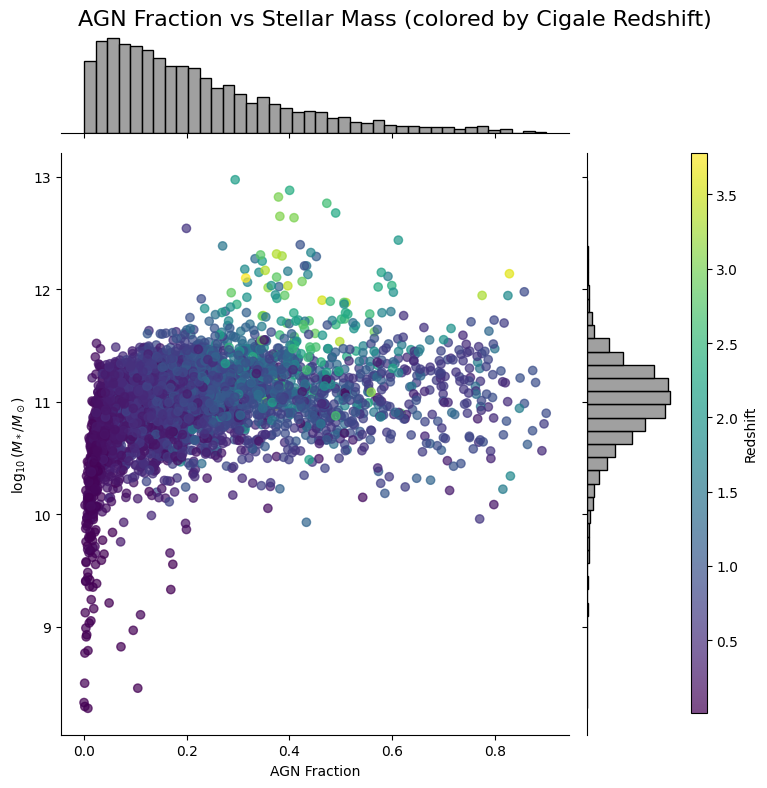

In [25]:
# Compute log stellar mass
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])

# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    y='log_stellar_mass',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['bayes.agn.fracAGN'],
    catalog_pd['log_stellar_mass'],
    c=catalog_pd['bayes.universe.redshift'],
    cmap='viridis',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title
g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('AGN Fraction vs Stellar Mass (colored by Cigale Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])  # [left, bottom, width, height]
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()


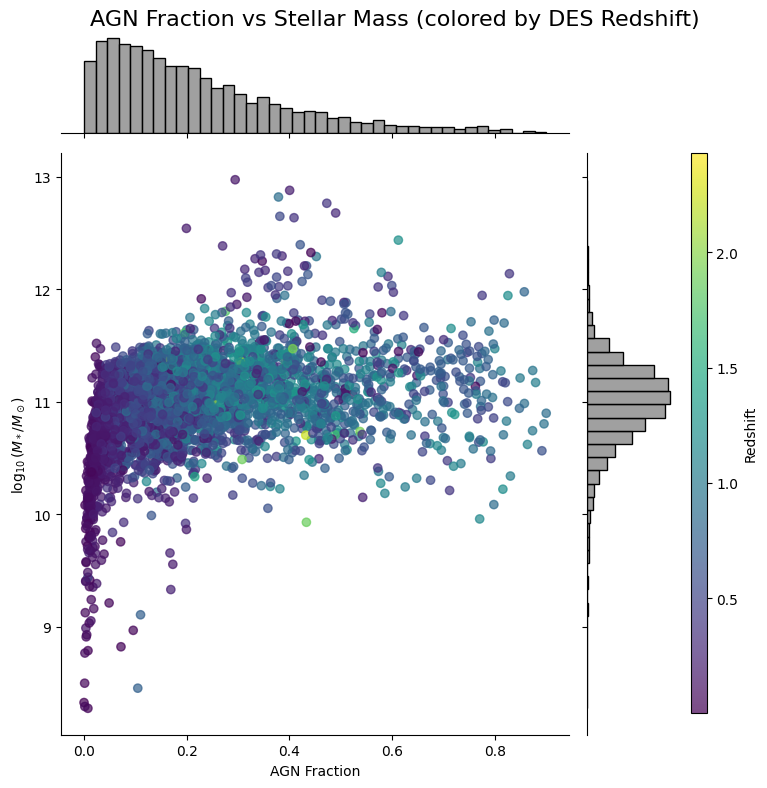

In [24]:
# Compute log stellar mass
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])

# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    y='log_stellar_mass',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['bayes.agn.fracAGN'],
    catalog_pd['log_stellar_mass'],
    c=catalog_pd['DESY6_dnf_z'],
    cmap='viridis',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title
g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('AGN Fraction vs Stellar Mass (colored by DES Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])  # [left, bottom, width, height]
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()

## SFR vs Stellar Mass , colored by redshift

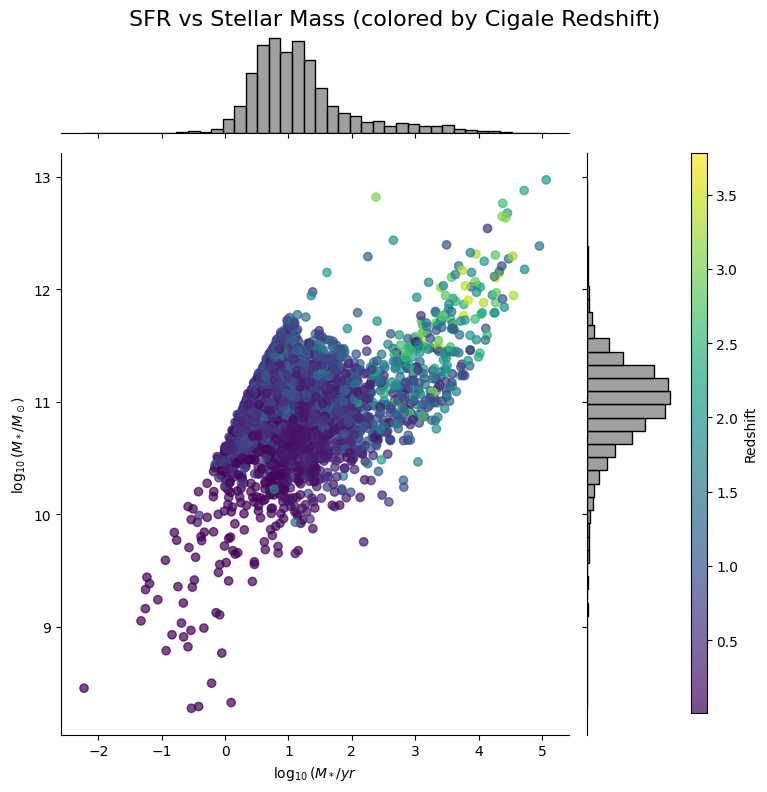

In [31]:
# Compute log stellar mass and log star formation rate
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])
catalog_pd['log_sfr_permass'] = np.log10(catalog_pd['bayes.sfh.sfr'])

# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='log_sfr_permass',
    y='log_stellar_mass',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['log_sfr_permass'],
    catalog_pd['log_stellar_mass'],
    c=catalog_pd['bayes.universe.redshift'],
    cmap='viridis',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='log_sfr_permass',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title
g.set_axis_labels(r'$\log_{10}(M_*/yr $', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('SFR vs Stellar Mass (colored by Cigale Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])  # [left, bottom, width, height]
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()

KeyError: 'bayes.universe.redshift'

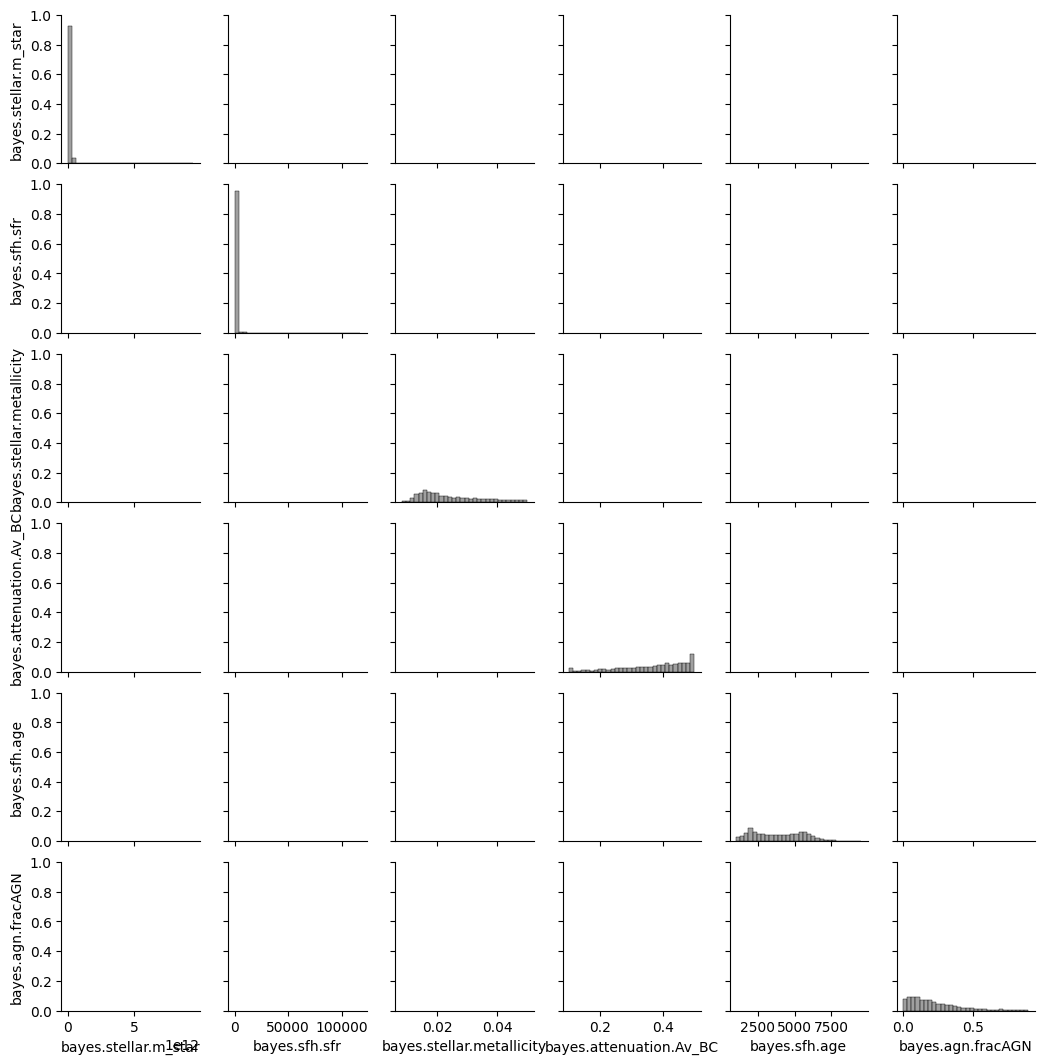

In [ ]:






# Select the 6 properties to compare
properties = ['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity','bayes.attenuation.Av_BC','bayes.sfh.age' ,'bayes.agn.fracAGN']

# Create a log column if not already done


# Drop rows with any missing values in selected properties
plot_df = catalog_pd[properties].dropna()

# Initialize PairGrid
g = sns.PairGrid(
    data=plot_df,
    vars=properties,
    height=1.8,
    aspect=1
)

# Diagonal: histograms
g.map_diag(sns.histplot, color='grey', bins=30)

# Off-diagonal: scatter plots colored by redshift
g.map_offdiag(
    sns.scatterplot,
    hue=plot_df['bayes.universe.redshift'],
    palette='viridis',
    alpha=0.7,
    s=10,
    linewidth=0
)

# Add a legend (colorbar-like legend for hue)
g.add_legend(title="Redshift", label_order=None, adjust_subtitles=True)

# Optional: tighten layout
plt.subplots_adjust(top=0.95)
g.fig.suptitle('6x6 Property Comparison Grid (Colored by Redshift)', fontsize=16)

plt.show()
